## Read 2pt for test

In [1]:
import numpy as np
import gvar as gv

from lametlat.utils.plot_settings import *
from lametlat.preprocess.read_raw import pt2_to_meff, pt2_to_meff_solve
from lametlat.utils.resampling import bootstrap, bs_ls_avg
from lametlat.gsfit.Lanczos.t_matrix import T_Matrix, cut_spurious
from lametlat.utils.constants import *
from lametlat.utils.funcs import constant_fit

a = 0.04
pt2_data = np.loadtxt("data/c2pt.CG52bxp00_CG52bxp00.SS.meson_g15.PX0_PY0_PZ0.real", delimiter=',')
print(np.shape(pt2_data))
pt2_data = pt2_data.swapaxes(0, 1)[1:] # remove the first row, which is the time
pt2_bs, _ = bootstrap(pt2_data, samp_times=100, bin=5)
print(np.shape(pt2_bs))

(64, 315)
(100, 64)


0.30028(65)


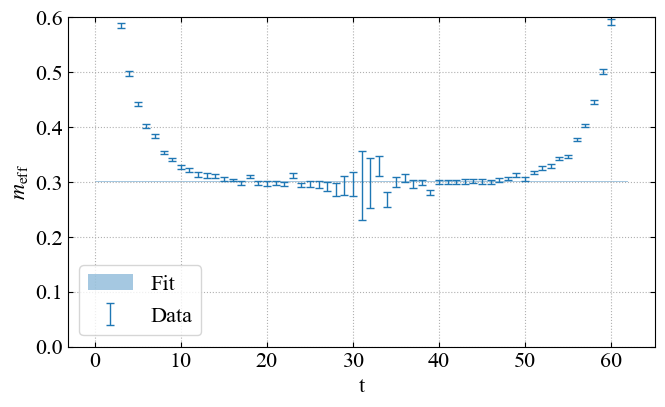

In [2]:
meff_bs = [pt2_to_meff_solve(pt2_bs[i], boundary="periodic") for i in range(len(pt2_bs))]
meff_avg = bs_ls_avg(meff_bs) * GEV_FM / a

# Clean NaN values in meff_avg
meff_avg = np.array([x if not np.isnan(x.mean) else gv.gvar(0, 10) for x in meff_avg])

fit_res = constant_fit(meff_avg[15:30])

print(fit_res)

fig, ax = default_plot()
ax.errorbar(np.arange(len(meff_avg)), gv.mean(meff_avg), yerr=gv.sdev(meff_avg), label='Data', **errorb)
ax.fill_between(np.arange(len(meff_avg)), gv.mean(fit_res) - gv.sdev(fit_res), gv.mean(fit_res) + gv.sdev(fit_res), alpha=0.4, label='Fit')
ax.set_xlabel('t', **fs_p)
ax.set_ylabel(r'$m_{\rm eff}$', **fs_p)
plt.ylim(0., 0.6)
plt.legend(**fs_p)
plt.tight_layout()
plt.show()

In [3]:
n_conf = 0
m = 4
pt2_norm = pt2_bs[n_conf] / pt2_bs[n_conf][0]

t_matrix_class = T_Matrix(pt2_norm, m=4)
t_matrix = t_matrix_class.main(ifcheck=True)

>>> check the alpha 2 from the t-matrix:  (0.35221115052743796+0j)
>>> check the alpha 2 from the pt2:  0.3522111505274377


/tmp/ipykernel_2385681/2546349296.py:23: RuntimeWarning: invalid value encountered in log
  energy_states = - GEV_FM / a * np.log( eigenvalues )


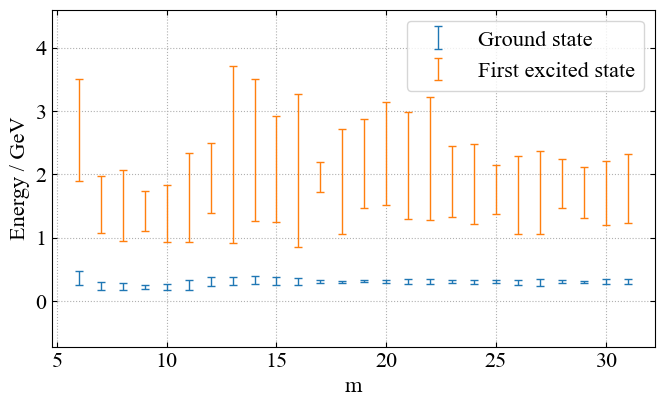

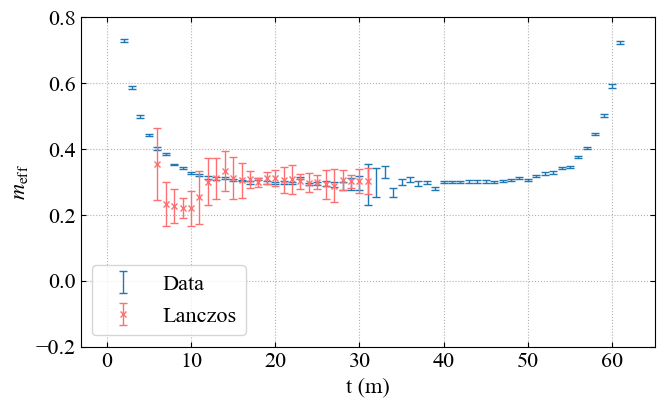

>>> Ground state energy:  [0.35407909 0.23227086 0.22621315 0.220887   0.22024009 0.25327681
 0.30115724 0.31089452 0.33257518 0.31264446 0.30521263 0.30837752
 0.29921171 0.31187643 0.31306253 0.30515459 0.30787025 0.30221353
 0.29814835 0.30021248 0.29245516 0.28911581 0.30611439 0.30179
 0.30250823 0.30280843]


In [4]:

m_ls = np.arange(6, 32)
e0_gv, e1_gv = [], []


for m in m_ls:
    temp_e0, temp_e1 = [], []
    
    for n_conf in range(len(pt2_bs)):
        pt2_norm = pt2_bs[n_conf] / pt2_bs[n_conf][0]
        
        t_matrix_class = T_Matrix(pt2_norm, m=m)
        t_matrix = t_matrix_class.main(ifcheck=False)
        
        if np.isnan(t_matrix).any():
            print(f"NaN detected in t_matrix for m={m} and n_conf={n_conf}")
            print(t_matrix)
            
        # Calculate eigenvalues of the t_matrix
        eigenvalues = cut_spurious(t_matrix, tolerance=0.1)
        # Select eigenvalues with imaginary part smaller than threshold
        eigenvalues = eigenvalues[np.abs(eigenvalues.imag) < 1e-8].real
        # Calculate energy states
        energy_states = - GEV_FM / a * np.log( eigenvalues )
        energy_states = np.array([e for e in energy_states if not np.isnan(e) and e > 0])
        energy_states = np.sort(energy_states)
        
        if len(energy_states) > 1 and 1 > energy_states[0] > 0.1: # todo: constrain the range of g.s. energy
            temp_e0.append(energy_states[0])
            temp_e1.append(energy_states[1])

    if len(temp_e0) > 0 and len(temp_e1) > 0:
        e0_gv.append(bs_ls_avg(temp_e0))
        e1_gv.append(bs_ls_avg(temp_e1))


fig, ax = default_plot()
ax.errorbar(m_ls, gv.mean(e0_gv), yerr=gv.sdev(e0_gv), label='Ground state', **errorb)
ax.errorbar(m_ls, gv.mean(e1_gv), yerr=gv.sdev(e1_gv), label='First excited state', **errorb)
ax.set_xlabel('m', **fs_p)
ax.set_ylabel('Energy / GeV', **fs_p)
ax.set_ylim(auto_ylim([np.array(gv.mean(e0_gv)), np.array(gv.mean(e1_gv))], [np.array(gv.sdev(e0_gv)), np.array(gv.sdev(e1_gv))]))
plt.legend(loc='upper right', **fs_p)
plt.tight_layout()
plt.show()


fig, ax = default_plot()
ax.errorbar(np.arange(len(meff_avg)), gv.mean(meff_avg), yerr=gv.sdev(meff_avg), label='Data', **errorb)
ax.errorbar(m_ls, gv.mean(e0_gv), yerr=gv.sdev(e0_gv), label='Lanczos', marker='x', color=red, **errorb)
ax.set_xlabel('t (m)', **fs_p)
ax.set_ylabel(r'$m_{\rm eff}$', **fs_p)
plt.ylim(-0.2, 0.8)
plt.legend(**fs_p)
plt.tight_layout()
plt.show()

print(">>> Ground state energy: ", gv.mean(e0_gv))
